# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
> 
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [78]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the frame. 
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [14]:
l = 0.5
r = 0.125

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

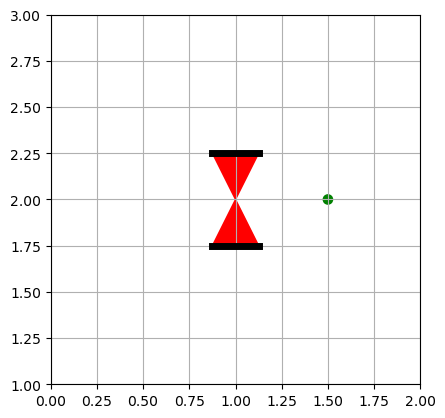

In [106]:
import numpy as np
import matplotlib.pyplot as plt


def draw_scooter(x, y, theta):
    fig, ax = plt.subplots()
    
    
    # Définir le cadre comme deux triangles (chaque plateforme)
    demi_longueur = l / 2
    hauteur_plateforme = l / 4  # hauteur de chaque triangle (choix arbitraire pour la visualisation)
    
    # Définir les sommets des plateformes gauche et droite
    plateforme_gauche = np.array([
        [hauteur_plateforme, demi_longueur],
        [0, 0],
        [-hauteur_plateforme,demi_longueur]
    ])
    
    plateforme_droite = np.array([
        [hauteur_plateforme, -demi_longueur],
        [0, 0],
        [-hauteur_plateforme,-demi_longueur]
    ])
    
    # Définir les positions des roues
    positions_roues = [
        [-r, demi_longueur],  # roue gauche bas
        [r, demi_longueur],   # roue gauche haut
        [-r, -demi_longueur],   # roue droite bas
        [r,-demi_longueur]     # roue droite haut
    ]
    
    # Matrice de rotation pour l'angle theta
    R = np.array([[np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    
    
    # Tourner et traduire les points des roues
    roues = [np.dot(R, pos) + [x, y] for pos in positions_roues]
    plateforme_gauche = [np.dot(R, pos) + [x, y] for pos in plateforme_gauche]
    plateforme_droite = [np.dot(R, pos) + [x, y] for pos in plateforme_droite]


    # Dessiner la plateforme gauche
    poly_gauche = plt.Polygon(plateforme_gauche, color='red')
    ax.add_patch(poly_gauche)
    
    # Dessiner la plateforme droite
    poly_droite = plt.Polygon(plateforme_droite, color='red')
    ax.add_patch(poly_droite)
    
    # Dessiner les roues comme des lignes
    ax.plot([roues[0][0], roues[1][0]], [roues[0][1], roues[1][1]], 'k-', lw=5)  # ligne noire pour la roue gauche
    ax.plot([roues[2][0], roues[3][0]], [roues[2][1], roues[3][1]], 'k-', lw=5)  # ligne noire pour la roue droite
    
    # Dessiner le marqueur de direction vers l'avant
    marqueur_avant = np.dot(R, [0.5, 0]) + [x, y]  # 50 cm (0,5 mètres) devant le cadre
    cercle_vert = plt.Circle((marqueur_avant[0], marqueur_avant[1]), 0.025, color='green', fill=True)  # rayon de 0.025 mètres, 50 cm est trop grand
    ax.add_patch(cercle_vert)
    
    # Définir les limites du graphique
    ax.set_xlim(x - 1, x + 1)
    ax.set_ylim(y - 1, y + 1)
    
    # Ajouter des lignes de grille pour référence visuelle
    ax.grid(True)
    
    # Définir un rapport d'aspect égal
    ax.set_aspect('equal')

# Exemple d'utilisation
draw_scooter(1, 2, 0)

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [105]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)
    return axes

#### On crée une version modifiée de draw_scooter qui prend en compte l'argument ax (un plot existant) et ajoute une légende sous chaque position

In [107]:
# On crée une version modifiée de draw_scooter qui prend en compte l'argument ax (un plot existant)
def draw_scooterv2(ax, x, y, theta, label):
    # Define the frame as two triangles (each platform)
    demi_longueur = l / 2
    hauteur_plateforme = l / 4  # height of each triangle (arbitrary choice for visualization)
    
    # Define the vertices of the left and right platforms
    plateforme_gauche = np.array([
        [hauteur_plateforme, demi_longueur],
        [0, 0],
        [-hauteur_plateforme, demi_longueur]
    ])
    
    plateforme_droite = np.array([
        [hauteur_plateforme, -demi_longueur],
        [0, 0],
        [-hauteur_plateforme, -demi_longueur]
    ])
    
    # Define the positions of the wheels
    positions_roues = [
        [-r, demi_longueur],  # bottom left wheel
        [r, demi_longueur],   # top left wheel
        [-r, -demi_longueur],   # bottom right wheel
        [r, -demi_longueur]     # top right wheel
    ]
    
    # Rotation matrix for the angle theta
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]
                 ])
    
    # Rotate and translate the wheel points
    roues = [np.dot(R, pos) + [x, y] for pos in positions_roues]
    plateforme_gauche = [np.dot(R, pos) + [x, y] for pos in plateforme_gauche]
    plateforme_droite = [np.dot(R, pos) + [x, y] for pos in plateforme_droite]

    # Draw the left platform
    poly_gauche = plt.Polygon(plateforme_gauche, color='red')
    ax.add_patch(poly_gauche)
    
    # Draw the right platform
    poly_droite = plt.Polygon(plateforme_droite, color='red')
    ax.add_patch(poly_droite)
    
    # Draw the wheels as lines
    ax.plot([roues[0][0], roues[1][0]], [roues[0][1], roues[1][1]], 'k-', lw=5)  # black line for the left wheel
    ax.plot([roues[2][0], roues[3][0]], [roues[2][1], roues[3][1]], 'k-', lw=5)  # black line for the right wheel
    
    # Draw the forward direction marker
    marqueur_avant = np.dot(R, [0.5, 0]) + [x, y]  # 50 cm (0.5 meters) in front of the frame
    cercle_vert = plt.Circle((marqueur_avant[0], marqueur_avant[1]), 0.025, color='green', fill=True)  # radius of 0.025 meters
    ax.add_patch(cercle_vert)
    
    # Annotate the position used
    ax.text(x, y - 0.6, label, ha='center', fontsize=12)


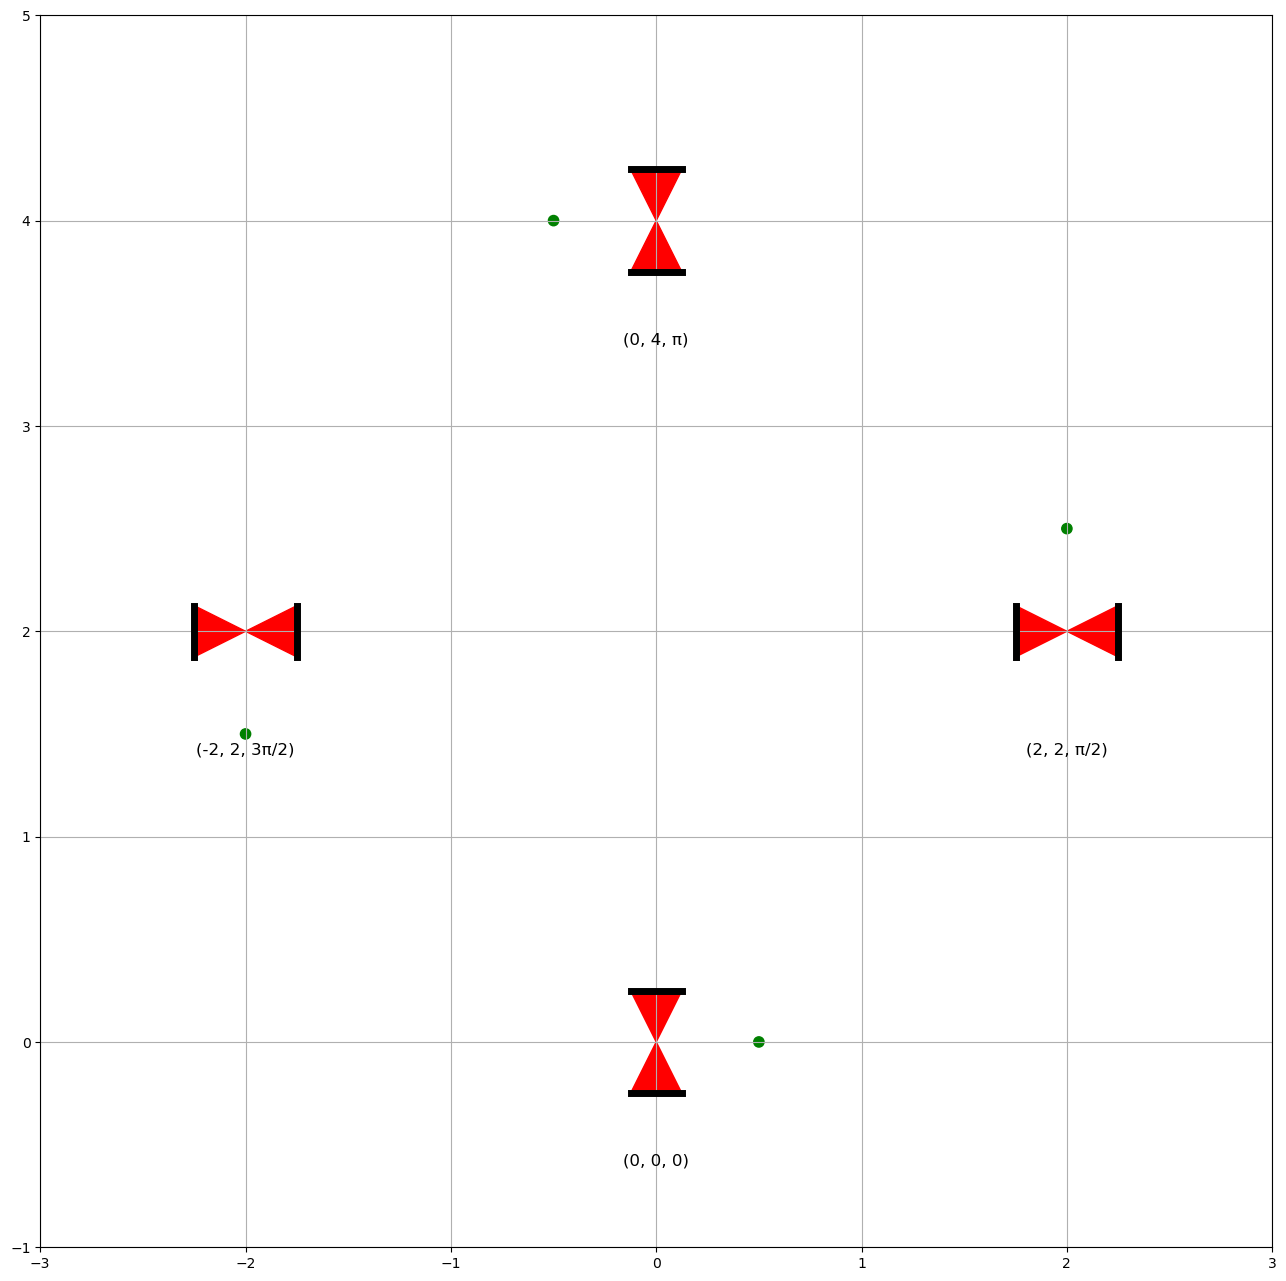

In [112]:
axes = draw_arena(-3, 3, -1, 5)
scooter_positions = [
    (0, 0, 0, "(0, 0, 0)"),
    (2, 2, np.pi/2, "(2, 2, π/2)"),
    (0, 4, np.pi, "(0, 4, π)"),
    (-2, 2, 3*np.pi/2, "(-2, 2, 3π/2)")
]

for pos in scooter_positions:
    draw_scooterv2(axes, pos[0], pos[1], pos[2], pos[3])
plt.show()

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

the velocity of the center of each wheel is given by :
<br>
$$
\begin{aligned}
v_l & =r \omega_l \\
v_r & =r \omega_r
\end{aligned}
$$
<br>
The velocity of the wheel axis center C can be computed as the average of the velocities of the two wheels:
<br>
$$
v_C=\frac{v_l+v_r}{2}=\frac{r}{2}\left(\omega_l+\omega_r\right)
$$
<br>
The direction of the velocity of the center of the wheel axis is the direction of the vector (because θ=0  when the front of the scooter faces the right ( ex ) and  θ=π/2  when it faces upwards ( ey )), thus:
<br>
$$
\begin{aligned}
& \dot{x}=v_C \cos \theta \\
& \dot{y}=v_C \sin \theta
\end{aligned}
$$
<br>
Finally, the angular velocity of the scooter is given by the difference of the velocities of the two wheels divided by the distance between the wheels:
<br>
$$
\dot{\theta}=\frac{v_r-v_l}{l}=\frac{r}{l}\left(\omega_r-\omega_l\right)
$$
<br>
Therefore, the differential equations relating  are:
<br>
$$
\begin{aligned}
& \dot{x}=\frac{r}{2}\left(\omega_l+\omega_r\right) \cos \theta \\
& \dot{y}=\frac{r}{2}\left(\omega_l+\omega_r\right) \sin \theta \\
& \dot{\theta}=\frac{r}{l}\left(\omega_r-\omega_l\right)
\end{aligned}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.


The angular velocity, $\dot{\theta}$, is a function of $\omega_l$ and $\omega_r$ :  \\
<br>
$$
\begin{aligned}
\dot{\theta} = \frac{r}{l} (\omega_r - \omega_l) \\
\end{aligned}
$$
<br>


As such, if $\omega_l$ and $\omega_r$ are continuously differentiable functions, then $\dot{\theta}$ is also. Consequently, $\theta$ is a continuously differentiable function. This implies that $\cos(\theta)$ and $\sin(\theta)$ are also continuously differentiable. Moreover, since $\dot{x}$ and $\dot{y}$ are functions of $\omega_l$, $\omega_r$, and $\theta$, it follows that $\dot{x}$ and $\dot{y}$ are continuously differentiable.

Therefore, based on the UNIQUENESS, CONTINUITY, and EXISTENCE theorems, we can conclude that the system is well-posed.



🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

If $\omega_l$ and $\omega_r$ are constants:

$$ \quad \quad x(t) =  \frac{l}{2}\frac{\omega_r+\omega_l}{\omega_r-\omega_l} \sin(\theta(t)) + x_0 $$



$$ \quad \quad y(t) = - \frac{l}{2}\frac{\omega_r+\omega_l}{\omega_r-\omega_l} \cos(\theta(t)) + y_0 $$

$$\quad \quad \theta(t) = \frac{r}{l}\left(\omega_r-\omega_l\right).t + \theta_0 $$


We can see that these solutions are finite for $t < \infty$.
Therefore, the maximal solution associated to any initial state is global.

If  $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$, the system becomes depend on the variables x, y, and 𝜃, the variation of these variables over time can tend towards infinity with certain initial values.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [116]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [117]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = (r/2) * (omega_r + omega_l)*cos(theta)
    dy = (r/2) * (omega_r + omega_l)*sin(theta)
    dtheta = (r/l) * (omega_r - omega_l)
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [120]:
# Define initial conditions
initial0 = np.array([0.0, 0.0, 0.0])

# Define time interval
t_span = [0.0, 4.0]

# Call solve_ivp
result = solve_ivp(fun, t_span, initial0, dense_output=True)
rt = result["t"]
x = result["y"][0]
y = result["y"][1]
theta = result["y"][2]
sol = result["sol"]

# Evaluate the solution at various times
t_eval = [0, 1, 2, 3, 4]  # Time points to evaluate
xytheta_solution = result.sol(t_eval)

# Print the solution
for i, t in enumerate(t_eval):
    print(f"Solution at t={t}: {xytheta_solution[:, i]}")

Solution at t=0: [0. 0. 0.]
Solution at t=1: [1.9997838  1.99945809 1.57079633]
Solution at t=2: [2.18124057e-03 4.00349973e+00 3.14159265e+00]
Solution at t=3: [-1.99697945  1.99667002  4.71238898]
Solution at t=4: [1.00338726e-03 7.26851674e-04 6.28318531e+00]


🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

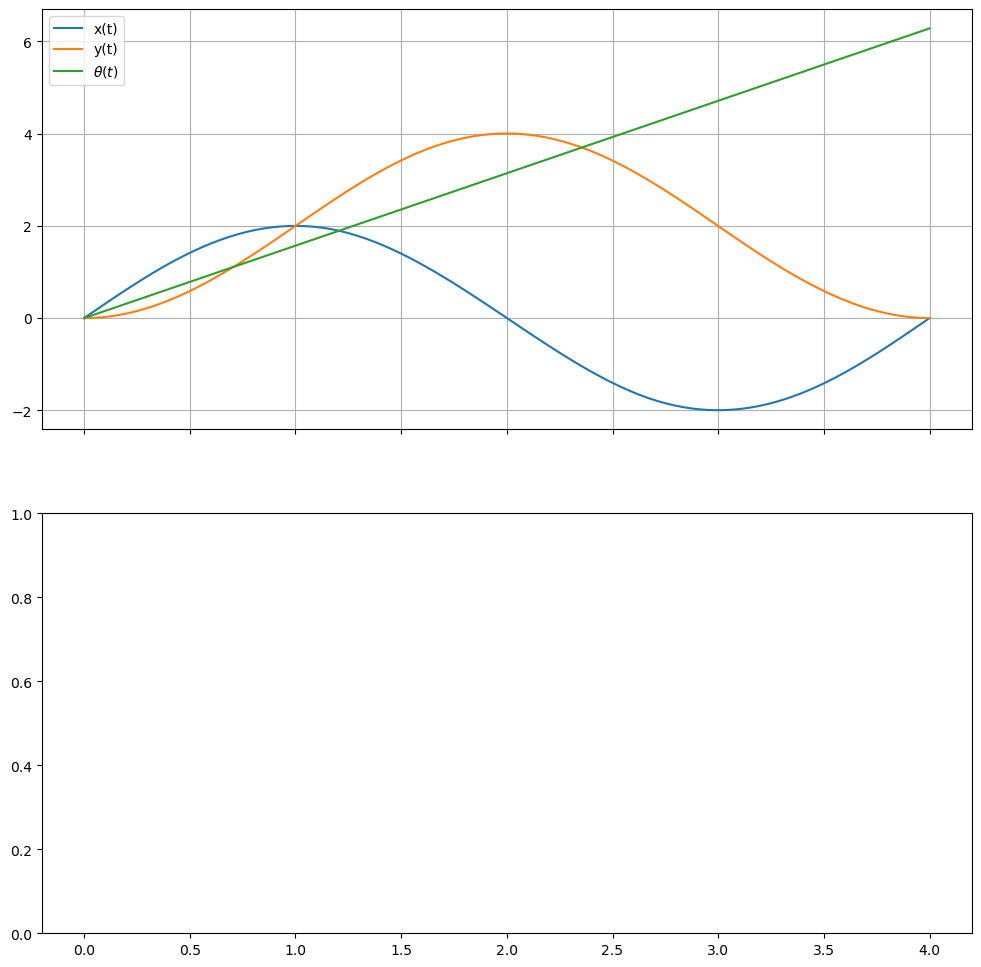

In [121]:
t = np.linspace(0.0, 4.0, 100)
x, y, theta = result["sol"](t)
fig=figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="x(t)")
ax1.plot(t, y, label="y(t)")
ax1.plot(t, theta, label=r"$\theta(t)$")
ax1.legend()

🧩 Use the simulation results to display the robot location every 0.5 second.

In [10]:
pass

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

**TODO**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

In [11]:
pass

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$. 

In [12]:
pass